<center><img src="https://raw.githubusercontent.com/mateuszk098/kaggle_notebooks/master/vehicle_speed_estimation/intro.jpg" width=1080px></center>

# <p style="font-family: 'JetBrains Mono'; font-weight: bold; font-size: 125%; color: #4A4B52; text-align: center">Vehicle Speed Estimation with YOLO11 &amp; OpenCV</p>

In [16]:
# %pip install -q -U gdown==5.2.0 supervision==0.24.0 ultralytics==8.3.12 lapx==0.5.11
import os
import subprocess
import warnings
from collections import defaultdict
from typing import Any

import cv2 as cv
import gdown
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import supervision as sv
from IPython.display import Video
from numpy.typing import ArrayLike, NDArray
from scipy.signal import savgol_filter
from ultralytics import YOLO

TICKSIZE = 12
FONT_COLOR = "#4A4B52"
GRADIENT_COLOR = "#BAB8B8"
BACKGROUND_COLOR = "#FFFCFA"
# TEXT = r"\textrm{{{}}}"

MATPLOTLIB_THEME = {
    "axes.labelcolor": FONT_COLOR,
    "axes.labelsize": TICKSIZE,
    "axes.facecolor": BACKGROUND_COLOR,
    "axes.titlesize": 16,
    "axes.grid": False,
    "axes.spines.bottom": False,
    "axes.spines.left": False,
    "axes.spines.right": False,
    "axes.spines.top": False,
    "xtick.labelsize": TICKSIZE,
    "xtick.color": FONT_COLOR,
    "ytick.labelsize": TICKSIZE,
    "ytick.color": FONT_COLOR,
    "figure.facecolor": BACKGROUND_COLOR,
    "figure.edgecolor": BACKGROUND_COLOR,
    "figure.titlesize": 16,
    "figure.dpi": 72,  # Locally Seaborn uses 72, meanwhile Kaggle 96.
    "text.color": FONT_COLOR,
    "font.size": TICKSIZE,
    # "text.usetex": True,
    "font.family": "Serif",
}
plt.rcParams.update(MATPLOTLIB_THEME)

ON_KAGGLE = os.getenv("KAGGLE_KERNEL_RUN_TYPE") is not None
VIDEO_URL = "https://drive.google.com/uc?export=download&id=17BLLWPJP4hpzLw135SI3rQPaWtItM0lR"
SOURCE_VIDEO = gdown.cached_download(VIDEO_URL, "m6-motorway-trim.mp4")


def imshow(img, figsize: tuple[int, int] = (11, 7)) -> None:
    plt.figure(figsize=figsize, tight_layout=True)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

File exists: m6-motorway-trim.mp4



<blockquote class="anchor" id="top" style="
    margin-right: auto; 
    margin-left: auto;
    padding: 10px;
    background-color: #004080;
    border-radius: 2px;
    border: 1px solid #004080;
">
<ol class="numbered-list" style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #F2F2F0;
    margin-top: 15px;
    margin-bottom: 15px;
">
    <li><a href="#introduction"><span style="color: #F2F2F0">Introduction &rarr; What this notebook covers?</span></a></li>
    <li><a href="#perspective_transform"><span style="color: #F2F2F0">Perspective Transform &rarr; What is perspective transformation, and why do we need it?</span></a></li>
    <li><a href="#speed_estimation"><span style="color: #F2F2F0">Speed Estimation &rarr; From pixels per frame to kilometres by hour.</span></a></li>
    <li><a href="#summary"><span style="color: #F2F2F0">Summary &rarr; The End.</span></a></li>
</ol>
</blockquote>

# <b> <span style="font-family: 'JetBrains Mono'; font-weight: bold; color: #4A4B52">1</span> <span style='color: #004080'>|</span> <span style="font-family: 'JetBrains Mono'; font-weight: bold; color: #4A4B52">Introduction</span></b><a class="anchor" id="introduction"></a> [↑](#top)

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    font-weight: bold;
    color: #4A4B52;
">
    <b><span style="color: #004080">&#x25FC </span>Description</b>
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    This notebook explores a practical approach to vehicle speed estimation using computer vision techniques. The video footage we are working with is captured from a CCTV camera overlooking the M6 highway near Knutsford, UK, specifically at $(53.306230, -2.406044)$. The video is available on YouTube, providing an accessible dataset for this project.
</p>
    
<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    font-weight: bold;
    color: #4A4B52;
">
    <b><span style="color: #004080">&#x25FC </span>Steps</b> 
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    The goal is to demonstrate a simple yet effective method for estimating vehicle speeds using cutting-edge computer vision technologies. We will use the latest <strong>YOLO11</strong> model for object detection and tracking to identify vehicles within the video frames.<br>
    Once vehicles are detected, we will perform a perspective transformation using <strong>OpenCV</strong> to project points from the camera’s view onto the road plane. This transformation allows us to map vehicle movements more accurately in the real world, compensating for the distortion caused by the camera's viewpoint.<br>
    <strong>The following steps will be covered:</strong>
    <ol style="
        font-size: 16px;
        font-family: 'JetBrains Mono';
        margin-top: 12px;
        margin-bottom: 12px;
        list-style-type: square;
    ">
        <li>Object detection and tracking will be performed using the latest <strong>YOLO11</strong> model and ByteTrack.</li>
        <li>Perspective transformation and point projection using <strong>OpenCV</strong> will be applied to map vehicle movement onto the road plane, accounting for the camera's viewpoint distortion.</li>
        <li>Video annotation will be done using the <strong>supervision</strong> library to display vehicle positions and estimated speeds on the frames.</li>
    </ol>
</p>
<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    The main objective is to show how vehicle speed estimation can be achieved in a few simple steps, providing a basic but functional framework that can be expanded for more advanced traffic analysis tasks.
</p>

# <b> <span style="font-family: 'JetBrains Mono'; font-weight: bold; color: #4A4B52">2</span> <span style='color: #004080'>|</span> <span style="font-family: 'JetBrains Mono'; font-weight: bold; color: #4A4B52">Perspective Transform</span></b><a class="anchor" id="perspective_transform"></a> [↑](#top)

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    Firstly, let's have a look at the original video. I trimmed it to only one minute for demo purposes.
</p>

In [17]:
Video(SOURCE_VIDEO, width=960, height=540)

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    When estimating vehicle speed using video footage, a simple approach might involve measuring the pixel displacement of vehicles between consecutive frames. <strong>However, this naive method is flawed due to the distortion caused by the camera's perspective.</strong> Vehicles closer to the camera appear to cover a greater distance in pixels per frame than those farther away, even if both vehicles are moving at the same speed. This distortion occurs because the camera's view is not directly overhead, but rather at an angle, causing objects to appear smaller as they move further from the camera.<br><br>
    <strong>To correct for this perspective distortion, we must eliminate the effects of the camera’s viewpoint and map the observed movement onto a real-world plane.</strong> This is where OpenCV's <code>getPerspectiveTransform</code> function comes into play. This function helps to compute a transformation matrix that warps the original camera view into a desired one, which in this case, is a top-down bird's-eye view, enabling us to accurately estimate vehicle movement.<br><br>
    Mathematically, <code>getPerspectiveTransform</code> works by mapping four points from the original camera view (the source points) to four corresponding points in the top-down view (the destination points). These source and destination points are usually manually selected to correspond to known reference points in both views, like lane markers or road boundaries.<br><br>
    OpenCV uses the following relation to compute the perspective transformation:
    <figure>
        <center><img src="https://raw.githubusercontent.com/mateuszk098/kaggle_notebooks/master/vehicle_speed_estimation/projective_matrix.jpg" width=540px></center><br>
        <center><figcaption><b style="font-size: 16px; font-family: 'JetBrains Mono'">Perspective Transform. Picture Source: <a href="https://theailearner.com/tag/cv2-getperspectivetransform/" style="color:#FFB74D">https://theailearner.com/tag/cv2-getperspectivetransform/</b></a>.</figcaption></center>
    </figure>
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    The $(x,y)$ are the coordinates of a point in the original image (camera view). $M$ is the $3\times3$ perspective transformation matrix. The $(x',y')$ are the coordinates in the transformed (bird's-eye) view. The $t_i$ is a scaling term introduced by the perspective transformation. This transformation allows us to project the apparent movement of vehicles in the image space to a consistent real-world scale, correcting for the distortion caused by the camera's perspective. Consequently, the vehicle speed can be estimated more accurately by measuring displacement in this corrected space.<br><br>
</p>

In [18]:
class PointMarker:
    """Mark points on an image using Left Mouse Button click."""

    def __init__(self, window: str = "Image") -> None:
        self._window = window
        self._points: list[tuple[int, int]] = list()

    def __call__(self, image: NDArray, inplace: bool = False) -> list[tuple[int, int]]:
        return self.mark(image, inplace)

    @property
    def points(self) -> list[tuple[int, int]]:
        return self._points

    def mark(self, image: NDArray, inplace: bool = False) -> list[tuple[int, int]]:
        if not inplace:
            image = image.copy()
        cv.namedWindow(self._window, cv.WINDOW_NORMAL)
        cv.setMouseCallback(self._window, self._record_point, param=image)

        while True:
            cv.imshow(self._window, image)
            if cv.waitKey(1) == ord("q"):
                break

        cv.destroyAllWindows()
        return self._points

    def _record_point(self, event: int, x: int, y: int, flags: int, image: Any | None) -> None:
        if event == cv.EVENT_LBUTTONDOWN:
            self._points.append((x, y))
            if image is not None:
                self._draw_point(image, (x, y))

    def _draw_point(self, image: NDArray, point: tuple[int, int]) -> None:
        cv.drawMarker(image, point, (0, 123, 255), cv.MARKER_CROSS, 20, 4, cv.LINE_AA)

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    In the image below, I marked four points, $A$, $B$, $C$ and $D$, that we map into a bird's-eye perspective. For points marking, we can, for example, use the above simple <code>PointMarker</code> class.
</p>

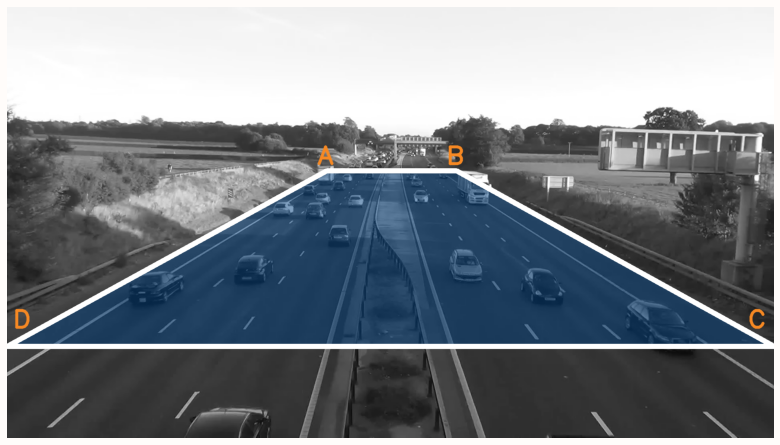

In [19]:
cap = cv.VideoCapture(SOURCE_VIDEO)
ret, img = cap.read()
cap.release()

img = cv.cvtColor(cv.cvtColor(img, cv.COLOR_BGR2GRAY), cv.COLOR_GRAY2BGR)

color1 = sv.Color.from_hex("#004080")
color2 = sv.Color.from_hex("#f78923")
poly = np.array(((800, 410), (1125, 410), (1920, 850), (0, 850)))

img = sv.draw_filled_polygon(img, poly, color1, 0.5)
img = sv.draw_polygon(img, poly, sv.Color.WHITE, 12)
img = sv.draw_text(img, "A", sv.Point(800, 370), color2, 2, 6)
img = sv.draw_text(img, "B", sv.Point(1125, 370), color2, 2, 6)
img = sv.draw_text(img, "C", sv.Point(1880, 780), color2, 2, 6)
img = sv.draw_text(img, "D", sv.Point(40, 780), color2, 2, 6)

imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    The most crucial part is that we need to know the exact distance between $AB$ and $DC$ lines. <strong>Hopefully, Google Maps comes with a distance calculator for given coordinates. In this case, the blue zone is approximately $32$ meters wide and $140$ meters long.</strong><br><br>
    Since point correspondence is found, we can write another simple class: <code>Cam2WorldMapper</code>, that estimates perspective transform and maps given image points to world points.
</p>

In [20]:
class Cam2WorldMapper:
    """Maps points from image to world coordinates using perspective transform."""

    def __init__(self) -> None:
        self.M: NDArray | None = None

    def __call__(self, image_pts: ArrayLike) -> NDArray:
        return self.map(image_pts)

    def find_perspective_transform(self, image_pts: ArrayLike, world_pts: ArrayLike) -> NDArray:
        image_pts = np.asarray(image_pts, dtype=np.float32).reshape(-1, 1, 2)
        world_pts = np.asarray(world_pts, dtype=np.float32).reshape(-1, 1, 2)
        self.M = cv.getPerspectiveTransform(image_pts, world_pts)
        return self.M

    def map(self, image_pts: ArrayLike) -> NDArray:
        if self.M is None:
            raise ValueError("Perspective transform not estimated")
        image_pts = np.asarray(image_pts, dtype=np.float32).reshape(-1, 1, 2)
        return cv.perspectiveTransform(image_pts, self.M).reshape(-1, 2)

In [21]:
# A, B, C, D previously found in the image.
image_pts = [(800, 410), (1125, 410), (1920, 850), (0, 850)]
# M6 is roughly 32 meters wide and 140 meters long there.
world_pts = [(0, 0), (32, 0), (32, 140), (0, 140)] 

mapper = Cam2WorldMapper()
mapper.find_perspective_transform(image_pts, world_pts)
print(mapper.M)

[[  -0.027557   -0.050103      42.587]
 [-2.9606e-17    -0.52608      215.69]
 [         -0  -0.0031216           1]]


<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    Determining the $M$ matrix is half the battle. Now, let's look at how to estimate the vehicle speed.
</p>

# <b> <span style="font-family: 'JetBrains Mono'; font-weight: bold; color: #4A4B52">3</span> <span style='color: #004080'>|</span> <span style="font-family: 'JetBrains Mono'; font-weight: bold; color: #4A4B52">Speed Estimation</span></b><a class="anchor" id="speed_estimation"></a> [↑](#top)

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    To roughly estimate vehicle speed, we can use a simple method that involves tracking vehicle positions over multiple frames, mapping these positions to real-world coordinates, and then calculating the displacement between consecutive frames. Here’s a detailed breakdown of how this process works:
    <ol class="numbered-list" style="
        font-size: 16px;
        font-family: 'JetBrains Mono';
        margin-top: 12px;
        margin-bottom: 12px;
    ">
        <li><strong>Accumulate Coordinates:</strong>
        <ol style="
            font-size: 16px;
            font-family: 'JetBrains Mono';
            margin-top: 12px;
            margin-bottom: 12px;        
            list-style-type: square;
        ">
            <li>For each vehicle track, we collect the vehicle's coordinates over the last few frames, with the max number of frames being equal to the video's frame rate (FPS). These coordinates are initially in pixel space and represent where the vehicle is seen on the screen.</li>
            <li>Using OpenCV's <code>getPerspectiveTransform</code>, we map these pixel coordinates to real-world coordinates on the road plane, removing the camera perspective distortion.</li>
        </ol>
        </li>
        <li><strong>Calculate Displacement:</strong>
        <ol style="
            font-size: 16px;
            font-family: 'JetBrains Mono';
            margin-top: 12px;
            margin-bottom: 12px;        
            list-style-type: square;
        ">
            <li>After mapping the vehicle's position to world coordinates, we calculate the displacement between consecutive frames by differentiating the mapped points. This gives us the change in position $(dx, dy)$ in meters for each frame.</li>
            <li>As there can be some noise or outliers in the tracked positions, we take the median of the calculated values. This helps reduce the effect of anomalies and gives a more stable estimate of the vehicle's motion in both directions (to make it work in both directions, we need to take absolute values).</li>
        </ol>
        </li>
        <li><strong>Calculate Speed:</strong>
        <ol style="
            font-size: 16px;
            font-family: 'JetBrains Mono';
            margin-top: 12px;
            margin-bottom: 12px;        
            list-style-type: square;
        ">
            <li>The total distance traveled by the vehicle in the real world $dS$, over the accumulated frames is calculated using the Euclidean norm of the $(dx, dy)$ median values. This gives the distance the vehicle has traveled in meters per frame.</li>
            <li>Since the distance traveled is calculated per frame, we multiply $dS$ by the video's frame rate (FPS) to get the vehicle's speed in meters per second.</li>
            <li>Finally, to convert the speed from m/s to km/h, we multiply by a conversion factor of $3.6$ (since $1$ m/s = $3.6$ km/h).
        </ol>
        </li>
    </ol>
</p>
<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    All of the above is done by a simple class <code>Speedometer</code> that expects the object's trace over the last $N$ frames.
</p>

In [22]:
MPS_TO_KPH = 3.6


class Speedometer:
    """Estimates speed of objects in the world coordinates."""

    def __init__(self, mapper: Cam2WorldMapper, fps: int, unit: float = MPS_TO_KPH) -> None:
        self._mapper = mapper
        self._fps = fps
        self._unit = unit
        self._speeds: defaultdict[int, list[int]] = defaultdict(list)

    @property
    def speeds(self) -> defaultdict[int, list[int]]:
        return self._speeds

    def update_with_trace(self, idx: int, image_trace: NDArray) -> None:
        if len(image_trace) > 1:
            world_trace = self._mapper(image_trace)
            # Median displacement in x and y directions.
            # This stabilises after around several frames.
            dx, dy = np.median(np.abs(np.diff(world_trace, axis=0)), axis=0)
            ds = np.linalg.norm((dx, dy))
            self._speeds[idx].append(int(ds * self._fps * self._unit))

    def get_current_speed(self, idx: int) -> int:
        return self._speeds[idx][-1] if self._speeds[idx] else 0

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    The last thing we need to do is to write a detection loop. We will use <code>supervision</code> for video annotation and the latest YOLO11 for object detection. 
</p>
<blockquote cite="https://docs.ultralytics.com/models/yolo11/">
    <p style="
        font-size: 16px;
        font-family: 'JetBrains Mono';
        text-align: justify;
        text-justify: inter-word;
    ">
        <em>YOLO11 is the latest iteration in the Ultralytics YOLO series of real-time object detectors, redefining what's possible with cutting-edge accuracy, speed, and efficiency. Building upon the impressive advancements of previous YOLO versions, YOLO11 introduces significant improvements in architecture and training methods, making it a versatile choice for a wide range of computer vision tasks.</em>
    </p>
</blockquote>

In [23]:
# Custom color palette for object tracking.
colors = ("#007fff", "#0072e6", "#0066cc", "#0059b3", "#004c99", "#004080", "#003366", "#00264d")
color_palette = sv.ColorPalette(list(map(sv.Color.from_hex, colors)))

# The supervision VideoInfo provides some metadata about the video.
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO)
FPS = video_info.fps

# Polygonal zone that masks out detected objects that are outside it.
poly = np.array([(0, 410), (1920, 410), (1920, 900), (0, 900)])
zone = sv.PolygonZone(poly, (sv.Position.TOP_CENTER, sv.Position.BOTTOM_CENTER))

bbox_annotator = sv.BoxAnnotator(
    color=color_palette,
    thickness=2,
    color_lookup=sv.ColorLookup.TRACK,
)
trace_annotator = sv.TraceAnnotator(
    color=color_palette,
    position=sv.Position.CENTER,
    thickness=2,
    trace_length=FPS,
    color_lookup=sv.ColorLookup.TRACK,
)
label_annotator = sv.RichLabelAnnotator(
    color=color_palette,
    border_radius=2,
    font_size=16,
    color_lookup=sv.ColorLookup.TRACK,
    text_padding=6,
)

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    The most interesting and helpful thing here is the polygonal zone that masks out objects outside the defined polygon. This helps us to provide an effect of annotations that will smoothly appear and disappear.
</p>

In [24]:
yolo = YOLO("yolo11m.pt", task="detect")
speedometer = Speedometer(mapper, FPS)

output_video = "m6-motorway-annotated.mp4"
width, height = video_info.resolution_wh  # Inferenced image size
# YOLO expects the image size to be a multiple of 32
width, height = round(width / 32) * 32, round(height / 32) * 32
classes = [2, 5, 7]  # Car, Bus, Truck
conf = 0.4  # Detetion confidence threshold

with sv.VideoSink(output_video, video_info) as sink:
    for frame in sv.get_video_frames_generator(SOURCE_VIDEO):
        result = yolo.track(
            frame,
            classes=classes,
            conf=conf,
            imgsz=(height, width),
            persist=True,
            verbose=False,
            tracker="bytetrack.yaml",
        )
        detection = sv.Detections.from_ultralytics(result[0])
        # Mask out detections outside the zone.
        detection = detection[zone.trigger(detections=detection)]

        trace_ids = detection.tracker_id  # type: ignore
        speeds: list[int] = list()
        labels: list[str] = list()

        for trace_id in trace_ids:  # type: ignore
            image_trace = trace_annotator.trace.get(trace_id)
            speedometer.update_with_trace(int(trace_id), image_trace)
            current_speed = speedometer.get_current_speed(int(trace_id))
            speeds.append(current_speed)
            labels.append(f"#{trace_id} {current_speed} km/h")

        frame = cv.cvtColor(cv.cvtColor(frame, cv.COLOR_BGR2GRAY), cv.COLOR_GRAY2RGB)
        frame = bbox_annotator.annotate(frame, detection)  # type: ignore
        frame = trace_annotator.annotate(frame, detection)  # type: ignore
        frame = label_annotator.annotate(frame, detection, labels=labels)  # type: ignore
        sink.write_frame(frame)

In [25]:
compressed = "m6-motorway-annotated-comp.mp4"
subprocess.run(
    [
        "ffmpeg",
        "-i",
        output_video,
        "-crf",
        "18",
        "-preset",
        "veryfast",
        "-vcodec",
        "libx264",
        compressed,
        "-loglevel",
        "quiet",
        "-y",
    ]
)

Video(compressed, width=960, height=540)

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    Let's have a look at speed distributions. The upper plot show the vehicle's speed over frames. The video lasts one minute - 1500 frames; however, vehicles travelling towards us stay on the screen for only a few seconds, so the corresponding lines consist of at most 100 frames. We can see the mean speed there is higher and equals around $100$ km/h. Meanwhile, vehicles travelling in the opposite direction travel much slower, which is caused by the further formation of a traffic jam.
</p>

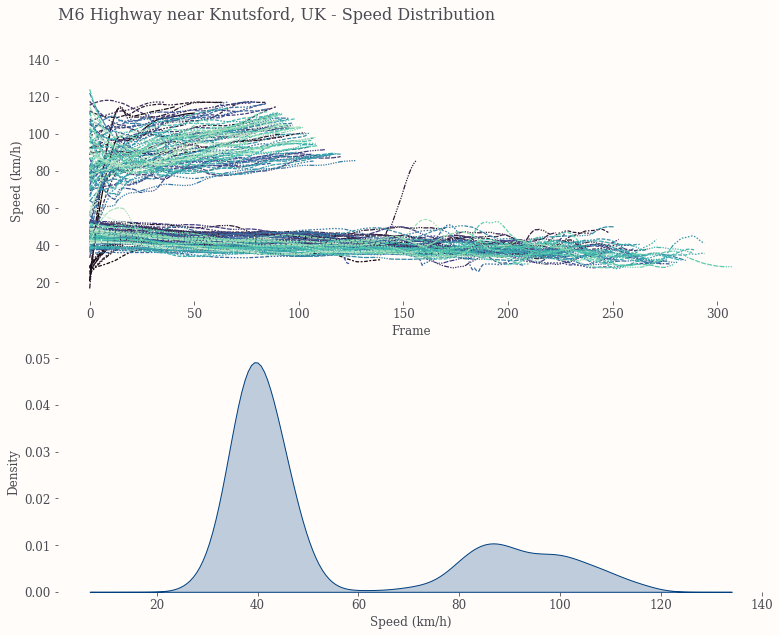

In [26]:
warnings.simplefilter("ignore")
speed_df = pd.DataFrame.from_dict(speedometer.speeds, orient="index").transpose()
speed_df = speed_df.clip(  # Remove extreme outliers and smooth the curve.
    lower=float(np.nanpercentile(speed_df, 1)),
    upper=float(np.nanpercentile(speed_df, 99)),
).apply(lambda x: savgol_filter(x, FPS, 2))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 9), tight_layout=True)
sns.lineplot(speed_df, palette="mako", linewidth=1.25, ax=ax1)
ax1.set_xlabel("Frame")
ax1.set_ylabel("Speed (km/h)")
ax1.get_legend().set_visible(False)
ax1.set_ylim(10, 140)
ax1.set_title(
    "M6 Highway near Knutsford, UK - Speed Distribution",
    loc="left",
    pad=40,
)
sns.kdeplot(speed_df.to_numpy().ravel(), fill=True, color="#004080", linewidth=1, ax=ax2)
ax2.set_xlabel("Speed (km/h)")
ax2.set_ylabel("Density")
plt.show()

# <b> <span style="font-family: 'JetBrains Mono'; font-weight: bold; color: #4A4B52">4</span> <span style='color: #004080'>|</span> <span style="font-family: 'JetBrains Mono'; font-weight: bold; color: #4A4B52">Summary</span></b><a class="anchor" id="summary"></a> [↑](#top)

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    In this notebook, we demonstrated a very basic but practical approach to estimating vehicle speed using computer vision. Starting with video footage from a CCTV camera overlooking the M6 highway, we applied the YOLO11 model for vehicle detection, followed by perspective transformation to map the detected vehicles' positions to real-world coordinates. By tracking vehicle movement across multiple frames and calculating displacement in meters, we were able to estimate vehicle speeds.<br><br>
    <center><img src="https://raw.githubusercontent.com/mateuszk098/kaggle_notebooks/master/vehicle_speed_estimation/the-end.gif" width=440px></center><br>
</p>

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    font-weight: bold;
    color: #4A4B52;
">
    <b><span style="color: #004080">&#x25FC </span>Source</b> 
    <ol style="
        font-size: 16px;
        font-family: 'JetBrains Mono';
        margin-top: 12px;
        margin-bottom: 12px;
        list-style-type: square;
    ">
        <li><a href="https://www.youtube.com/watch?v=PNCJQkvALVc" style="color:#FFB74D">https://www.youtube.com/watch?v=PNCJQkvALVc</a></li>
        <li><a href="https://docs.ultralytics.com/" style="color:#FFB74D">https://docs.ultralytics.com/</a></li>
        <li><a href="https://supervision.roboflow.com/latest/detection/core/" style="color:#FFB74D">https://supervision.roboflow.com/latest/detection/core/</a></li>
    </ol>
</p>
    
